# iPhone Project

*by Alexander Marinskiy*

## Part 2. Training model

### Create model

For this assignment, I decided to use the Resnet18 architecture. It shows good accuracy and at the same time it trains reasonable time. By default, the Resnet18 architecture is not represented in keras, so this repository on the github was used: https://github.com/qubvel/classification_models

In [ ]:
"""
# install the nessesary package
!pip install git+https://github.com/qubvel/classification_models.git
""

In [1]:
# import libraries
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

from classification_models.resnet import ResNet18

import tensorflow as tf
from tensorflow.contrib import lite

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

Using TensorFlow backend.


In [2]:
# ignore warnings
warnings.filterwarnings('ignore')

I decided to load pre-trained model because it might be a good starting point to train the model.

In [3]:
# Load pre-tained Resnet18 model
model = ResNet18(input_shape=(224,224,3), weights='imagenet', include_top=True)

# change the last layer
model.layers.pop()
last = model.layers[-1].output
x = Dense(2, activation="softmax")(last)
model = Model(model.input, x)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# compile model with adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Configure ImageDataGenerator

In [5]:
# set the batch size
batch_size = 32

# define directories for train and test
train_dir = 'iphones_dataset_train'
validation_dir = 'iphones_dataset_val'

Next step is to define ImageDataGenerators and add augmentation for training dataset. I used quite strong augmentation in order to avoid overfitting. For testing set I did't use augmentation, so that the test sample was as close as possible to the real data on which the model will work.

In [6]:
# Set ImageDataGenerator for training set. I used strong augmentation + rescaling.
train_datagen = ImageDataGenerator(rescale = 1./255., 
                                   rotation_range = 90,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   brightness_range = [0.3, 1.5],    
                                   shear_range = 0.4,
                                   zoom_range = 0.2,
                                   channel_shift_range = 20,
                                   vertical_flip = True,
                                   horizontal_flip = True)

# Set ImageDataGenerator for testing set. Note that here I used just rescaling and didn't use any augmentation
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

Here is the example of augmented images:

<img src="images/augmentation.jpg">

Now let's set flow_from_directory. The images are resized to 224*224 because it is the default size for Resnet18 architecture.

In [7]:
# Flow training images using train_datagen generator. 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical', 
                                                    target_size = (224, 224))     

# Flow validation images using test_datagen generator. Here I set turned off shuffling so that sklearn metriks worked correctly.
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size  = batch_size,
                                                         class_mode  = 'categorical', 
                                                         target_size = (224, 224),
                                                         shuffle=False)

Found 50144 images belonging to 2 classes.
Found 2846 images belonging to 2 classes.


### Set checkpoints

Model training takes a lot of time, and the process can be interrupted for various technical reasons. To save the progress in training the model, I used checkpoints. I saved the model after each epoch when val_score improved.

In [8]:
# set checkpoint
filepath="resnet18-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

### Fit the model

In [ ]:
# fit the model using fit generator
model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = train_generator.samples / batch_size,
            epochs = 100,
            validation_steps = validation_generator.samples / batch_size,
            verbose = 1,
            callbacks=[checkpoint])

### Compres the model

It turned out that GitHub does not accept files larger than 100 MB. In order to meet this restriction, I decided to use Tensorflow Lite, which is usually used for mobile devices. First of all, I converted the model:

In [9]:
# Converting keras model to tflite model
converter = lite.TFLiteConverter.from_keras_model_file('model.hdf5')
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 100 variables.
INFO:tensorflow:Converted 100 variables to const ops.


46791096

Now the **size of the model has decreased from 137 MB to 45 MB**, and such model can already be uploaded to the GitHab.

### Quality check

Now, I would like to assess how much the quality of the model has deteriorated in the process of such conversion. For this, the Average Precision metric will be used. This metric can be approximied as Area Under Precision-Recall Curve that will be used for the final evaluation of the project.

Let's get predictions with full model:

In [16]:
# get prdictions with original model
model = load_model('model.hdf5')

In [17]:
# get predictions
validation_generator.reset()
full_pred = model.predict_generator(validation_generator, 
                                    steps= validation_generator.samples / batch_size, 
                                    verbose=1)

89/88 [==============================] - 713s 8s/step


Now, let's get predictions with compressed model:

In [18]:
#create function for loading and rescaling images

def load_image(img_path):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255.
    
    return img_tensor

In [20]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Now lets walk through our validation set and get predictions for each photo
# I'm going to store predictions from compressed model in compr_pred
compr_pred = []
for subdir, dirs, files in os.walk(validation_dir):
    for file in files:
        input_data = load_image(os.path.join(subdir, file))
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        compr_pred.append(output_data[0])

Now, let's compare results:

In [21]:
# calculate avarage percision
average_precision_full = average_precision_score(validation_generator.classes, [x[1] for x in full_pred])
average_precision_compr = average_precision_score(validation_generator.classes, [x[1] for x in compr_pred])

# print results
print('Average precision-recall score for full model: {0:0.10f}'.format(average_precision_full))
print('Average precision-recall score for compressed model: {0:0.10f}'.format(average_precision_compr))

Average precision-recall score for full model: 0.9942834919
Average precision-recall score for compressed model: 0.9942834953


**We can see that results almost did not change after compression**

Now, one more thing. Let's plot precision-recall curve to check what it looks like

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.9943')

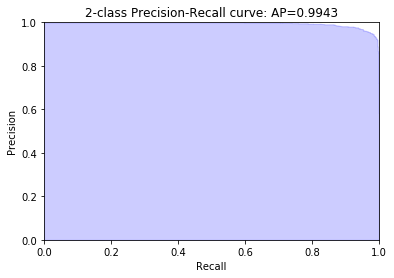

In [24]:
# plot the precision-recall curve
precision, recall, _ = precision_recall_curve(validation_generator.classes, [x[1] for x in compr_pred])
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision_compr))

All done :)